# Spapros Tutorial: Basic Evaluation

This tutorial shows how to to evaluate a probeset with the spapros evaluation pipeline.  
We examplary evaluate the probeset of 50 genes that was selected in our [basic selection tutoral](https://spapros.readthedocs.io/en/latest/tutorials/spapros_tutorial_basic_selection.html).

The used dataset contains 3k PBMCs from a healthy donor and is publicly available from
[10x Genomics](https://support.10xgenomics.com/single-cell-gene-expression/datasets/1.1.0/pbmc3k)
[here](http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz).  
You can also derive it from scanpy [here](https://scanpy.readthedocs.io/en/stable/generated/scanpy.datasets.pbmc3k.html#scanpy.datasets.pbmc3k), like we will do in this tutorial.

The preprocessed Anndata consists of log-normalized single cell RNAseq counts of 2638 cells for 13714 genes.

## Import packages and setup

To run the notebook locally, create a conda environment using this [environment.yaml](TODO link):

    conda create -f environment.yaml

Then add the conda environment as ipython kernel:

    python -m ipykernel install --user --name spapros --display-name Python (spapros)



In [1]:
import spapros
from spapros import ev, pl
import scanpy as sc

/big/st/strasserl/spapros/spapros/selection/selection_procedure.py:19: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
sc.settings.verbosity = 1
sc.logging.print_header()
print(f"spapros=={spapros.__version__}")

scanpy==1.8.1 anndata==0.7.8 umap==0.5.2 numpy==1.21.4 scipy==1.7.2 pandas==1.3.4 scikit-learn==1.0.1 statsmodels==0.13.1 python-igraph==0.9.8 pynndescent==0.5.5
spapros==0.1.0


## Load dataset and selected probeset

In [3]:
# Load the dataset
adata = sc.datasets.pbmc3k()

# Do preprocessing on a copy 
adata_pp = adata.copy()

# Basic filtering
sc.pp.filter_cells(adata_pp, min_genes=200)
sc.pp.filter_genes(adata_pp, min_cells=3)
adata_pp.var['mt'] = adata_pp.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata_pp, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
adata = adata[((adata_pp.obs.n_genes_by_counts < 2500) & (adata_pp.obs.pct_counts_mt < 5)), :]

# Calculate size factors
sc.pp.normalize_total(adata_pp, target_sum=1e4, key_added="size_factors")

# Logarithmize copy
sc.pp.log1p(adata_pp)

# Find highly variable genes
sc.pp.highly_variable_genes(adata_pp, min_mean=0.0125, max_mean=3, min_disp=0.5)

# Cluster celltypes
sc.tl.pca(adata_pp)
sc.pp.neighbors(adata_pp)
sc.tl.leiden(adata_pp, key_added="celltype")

# Actually filter read adata
adata = adata[:, adata.var["gene_ids"].isin(adata_pp.var["gene_ids"])]

# Logarithmize
sc.pp.log1p(adata)

# Save highly variable genes
adata.var["highly_variable"] = adata_pp.var["highly_variable"]

# Save size factors
adata.obs["size_factors"] = adata_pp.obs["size_factors"]

# Annotate cell types: 
adata.obs["celltype"] = adata_pp.obs["celltype"]

adata


/home/st/strasserl/anaconda3/envs/spapros/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:373: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


AnnData object with n_obs × n_vars = 2638 × 13714
    obs: 'size_factors', 'celltype'
    var: 'gene_ids', 'highly_variable'
    uns: 'log1p'

In [4]:
selection = ['PPBP', 'CCL5', 'GNLY', 'S100A8', 'S100A11', 'LST1', 'CD79A', 'LTB',
       'HLA-DQA1', 'GPX1', 'HLA-DQB1', 'IL32', 'FCER1G', 'NKG7', 'CD79B',
       'FCGR3A', 'GSTP1', 'HLA-DRB1', 'TYROBP', 'CD2', 'HLA-DMA', 'ATP6V0E1',
       'APOBEC3A', 'VAMP8', 'PSMB8', 'GZMB', 'COTL1', 'PPIB', 'UBB', 'AIF1',
       'ARPC1B', 'FCN1', 'LGALS2', 'SRGN', 'PSMA7', 'MS4A1', 'MT-ND5', 'CST7',
       'GIMAP5', 'GZMA', 'TCL1A', 'LYAR', 'PTPRCAP', 'CTSW', 'CD37',
       'HLA-DPA1', 'SDPR', 'HLA-DPB1', 'YWHAB', 'DYNLL1']

## Start the evaluation

In [5]:
evaluator = ev.ProbesetEvaluator(adata, verbosity=1)

In [6]:
evaluator.evaluate_probeset(selection)

## Visualize the results

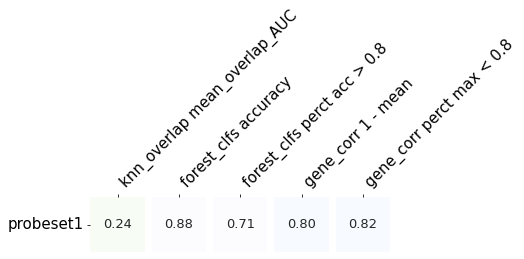

In [7]:
evaluator.plot_summary()

## What's next? 

You learned so far the very basic spapros evaluation probeset pipeline.  
There are several ways to customize and improve your evaluation with spapros. 
See our [advanced evaluation tutorial](https://spapros.readthedocs.io/en/latest/tutorials/spapros_tutorial_advanced_evaluation.html) if you want to learn more.
We also explain each available metric there (there are even more than shown here!) and show how to create pretty plots. 

**Note**:  
After running this tutorial, the results are stored in a directory, that is by default called `probeset_evaluation`.  
If you run another evaluation after this tutorial, be careful that you either specify another dir or delete the previously created results directory because otherwise parts will be overwritten and parts will be falsely reused!
If you do not want to save results, initialize the `ProbesetEvaluator` with `dir=None`.
